In [1]:
import numpy as np
from scipy import linalg
import sys
from numpy.random import choice
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 2000)

/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def visuals(mat, x=18, y=15):
    df = pd.DataFrame(mat)  # turn 2-d array to dataframe
    fig, ax = plt.subplots(figsize=(x, y))  # figure size
    sns.heatmap(df, annot=True)  # display both color and value
    # df
    pass

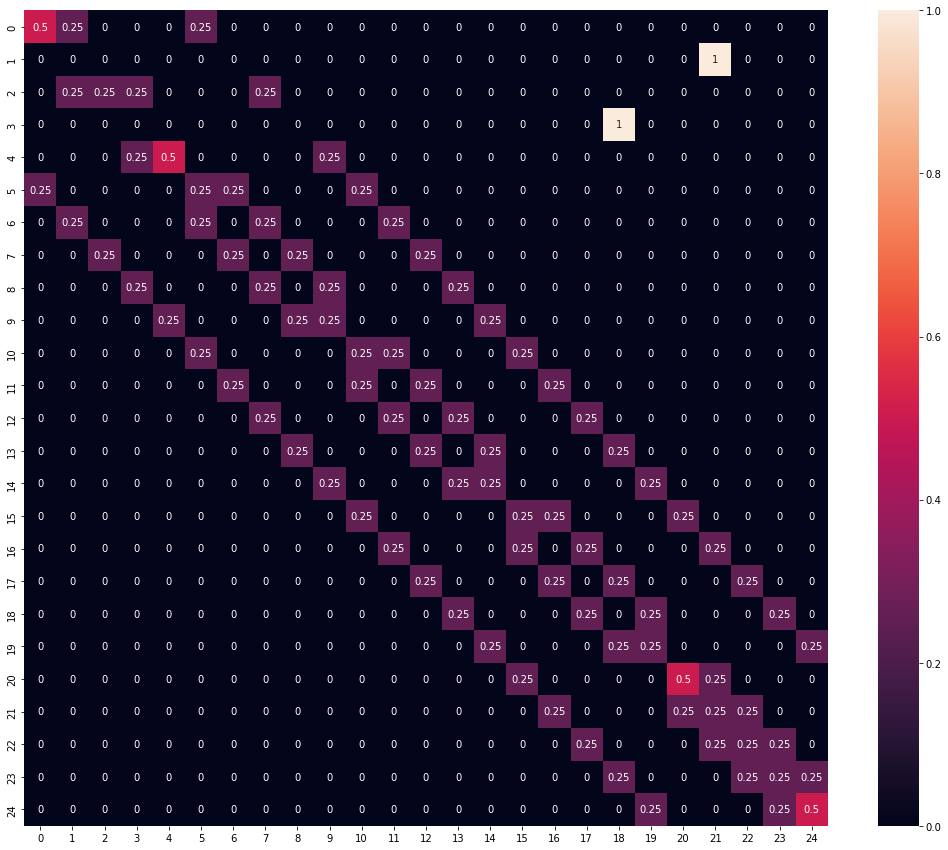

In [3]:
class Policy:
    def __init__(self):
        self.a = np.array(['left', 'right', 'up', 'down'])  # directions
        self.p = [0.25, 0.25, 0.25, 0.25]  # probabilities
        self.lx, self.ly = 5, 5  # gridworld size len(x), len(y)
        pass

    def step(self, x, y, a):
        if x == 0 and y == 1: return x + 4, y  # G1 -> G1'
        elif x == 0 and y == 3: return x + 3, y  # G2 -> G2'
        elif a == 'up': return self.up(x, y)  # go up
        elif a == 'down': return self.down(x, y)  # go down
        elif a == 'left': return self.left(x, y)  # go left
        elif a == 'right': return self.right(x, y)  # go right
        else: sys.exit(250)  # throw an error

    def transition(self, x, y):
        p_pi = np.zeros(self.lx * self.ly)
        start_state = x * self.lx + y  # from start state to end state
        for direction, probability in zip(self.a, self.p):
            new_x, new_y = self.step(x, y, direction)
            end_state = new_x * self.lx + new_y  # end state
            p_pi[end_state] += probability  # update state values
        return p_pi

    def smaller(self, a): return a if a == 0 else a - 1  # border rule
    def bigger(self, a): return a if a == 4 else a + 1  # border rule
    def up(self, x, y): return self.smaller(x), y  # move up
    def down(self, x, y): return self.bigger(x), y  # move down
    def left(self, x, y): return x, self.smaller(y)  # move left
    def right(self, x, y): return x, self.bigger(y)  # move right

    def next_move(self, x, y):  # return (x, y, comment)
        direction = choice(self.a, p=self.p)  # sampling
        if x == 0 and y == 1: return 4, y, 'A_A\''  # A -> A'
        elif x == 0 and y == 3: return 2, y, 'B_B\''  # B -> B'
        elif direction == 'up': return self.up(x, y)  # random up
        elif direction == 'down': return self.down(x, y)  # random down
        elif direction == 'left': return self.left(x, y)  # random left
        elif direction == 'right': return self.right(x, y)  # random right
        else: sys.exit(250)  # throw an error


pp = Policy()
transition_matrix = np.zeros((pp.lx * pp.ly, pp.lx * pp.ly))
pd.DataFrame(transition_matrix)

for i in range(pp.lx):  # scan x offset
    for j in range(pp.ly):  # scan y offset
        from_s = i * pp.lx + j  # transition matrix idx_x
        transition_p = pp.transition(i, j)  # calculate transitions from from_state to to_state
        transition_matrix[from_s] = transition_p  # update from_to transitions with each row(from_s)

visuals(transition_matrix)  # transition matrix visualization


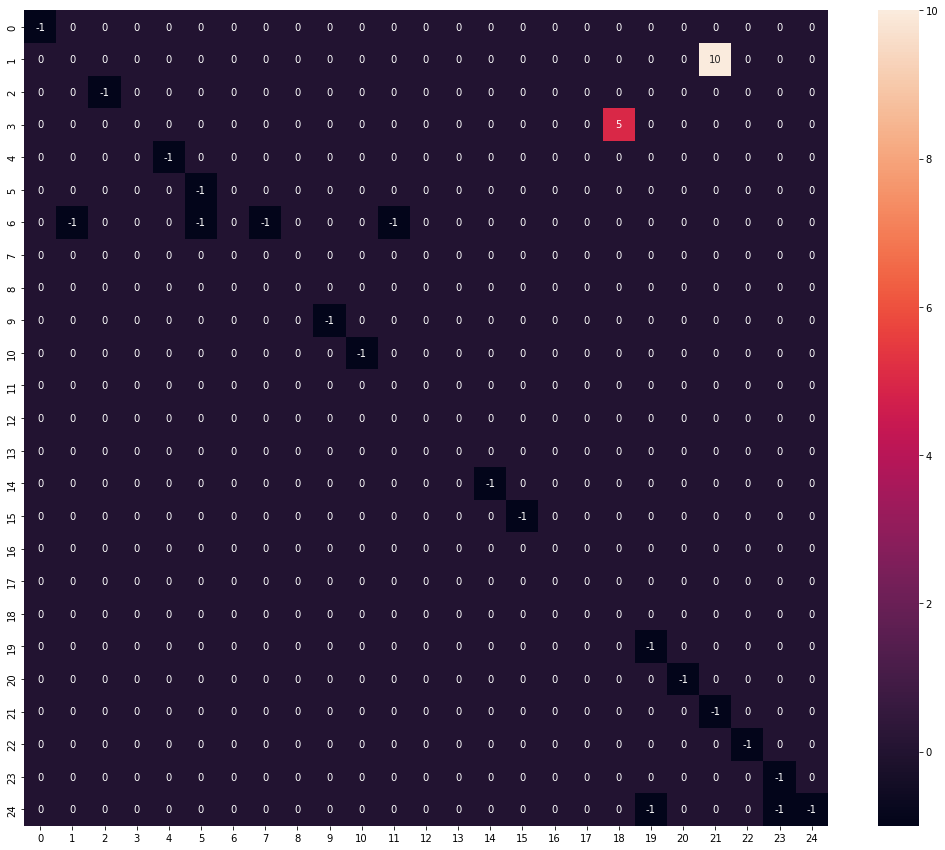

In [4]:
class Environment:
    def __init__(self, policy):
        self.pp = policy
        pass

    def __step_reward(self, x, y, a):
        if   x == 0 and y == 1: return 10  # G1, +10
        elif x == 0 and y == 3: return 5   # G2, +5
        elif x == 1 and y == 1: return -1  # B1, -1
        elif x == 4 and y == 4: return -1  # B2, -1
        elif a == 'up'        : return -1 if x == 0 else 0  # x, y, reward
        elif a == 'down'      : return -1 if x == 4 else 0  # x, y, reward
        elif a == 'left'      : return -1 if y == 0 else 0  # x, y, reward
        elif a == 'right'     : return -1 if y == 4 else 0  # x, y, reward
        else: sys.exit(250)  # never happened
        pass

    def rewards(self, x, y, a):
        new_x, new_y = self.pp.step(x, y, a)  # from s -> s'
        reward = self.__step_reward(x, y, a)  # take action and get reward
        return new_x, new_y, reward

    def transition(self, x, y):
        r_pi = np.zeros(self.pp.lx * self.pp.ly)  # init
        buf = np.zeros(2 * 4).reshape(-1, 2)  # calculate avg reward from s -> s'
        for i in range(4):
            a = self.pp.a[i]  # get action name
            new_x, new_y, reward = self.rewards(x, y, a)
            end_state = new_x * self.pp.lx + new_y  # end state
            buf[i] = np.array([end_state, reward])  # save all rewards
        buf = pd.DataFrame(buf).groupby(0).agg('mean').reset_index(drop=False).to_numpy()  # get avg rewards
        for [x, y] in buf:
            r_pi[int(x)] = y  # set avg rewards into R_pi(s)
        return r_pi  # return R_pi(s)


ee = Environment(pp)  # new environment
reward_matrix = np.zeros_like(transition_matrix)  # same size as transition matrix

for i in range(pp.lx):  # scan x offset
    for j in range(pp.ly):  # scan y offset
        from_s = i * pp.lx + j  # transition matrix idx_x
        transition_r = ee.transition(i, j)  # get transition_r
        reward_matrix[from_s] = transition_r  # update reward_matrix

visuals(reward_matrix)  # transition matrix visualization

In [5]:
R_expected = np.sum(transition_matrix * reward_matrix, axis=1, keepdims=True)  # expected reward for each state
R_expected.flatten().reshape(-1,5)  # reshape as gridworld

array([[-0.5 , 10.  , -0.25,  5.  , -0.5 ],
       [-0.25, -1.  ,  0.  ,  0.  , -0.25],
       [-0.25,  0.  ,  0.  ,  0.  , -0.25],
       [-0.25,  0.  ,  0.  ,  0.  , -0.25],
       [-0.5 , -0.25, -0.25, -0.25, -1.  ]])

***
Since **`V`** is the only thing we don't know, we should generate an Identity Matrix to complete this part: **`(1-rP)`**, then solve **`(1-rP)X=R`**
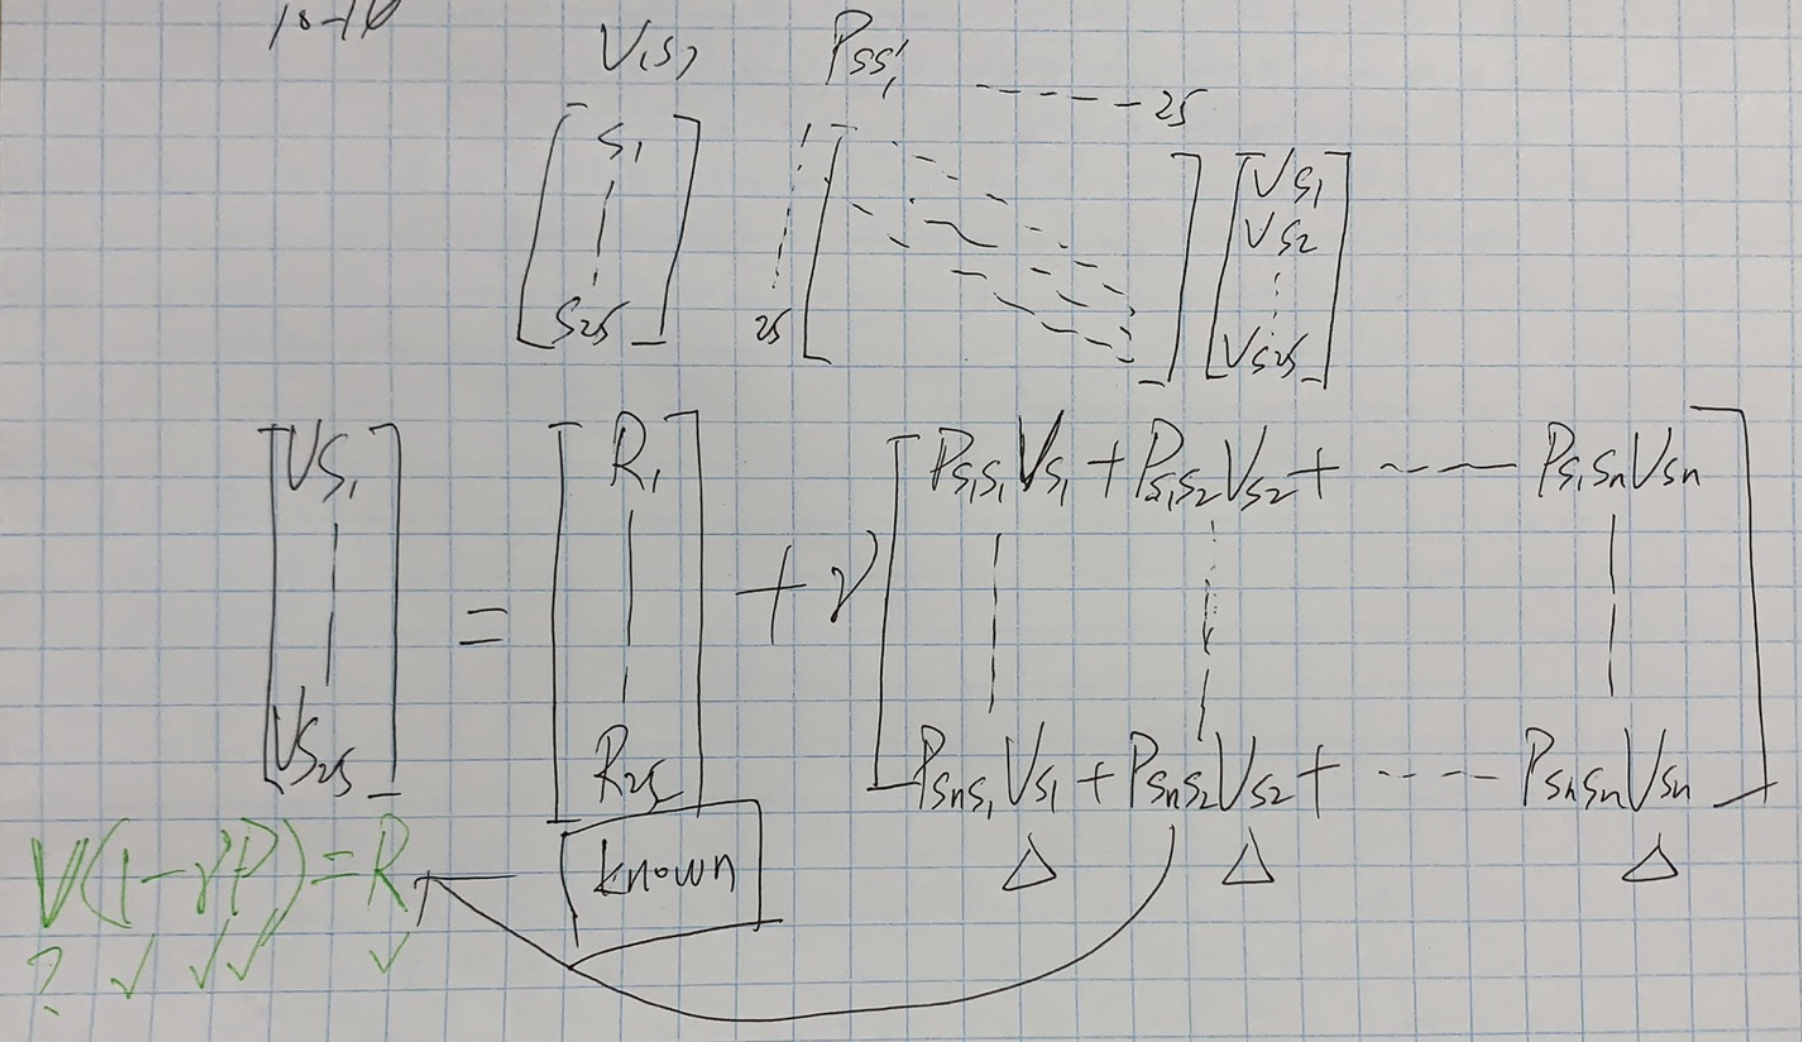
***

In [6]:
I = pd.DataFrame(np.eye(pp.lx * pp.ly, pp.lx * pp.ly))  # generate an Identity Matrix
A = I - 0.9 * transition_matrix  # prepare the left part of the Bellman Linear Equation
V = linalg.solve(A, R_expected)  # solving systems of nonlinear equations
final_result = V.flatten().reshape(-1,5)  # reshape as gridworld
final_result

array([[ 2.89733327,  8.50184288,  3.71959416,  3.97296568,  0.69063814],
       [ 0.80274957,  1.43273875,  1.44823798,  1.16438843, -0.06251689],
       [-0.45393462,  0.0593418 ,  0.1198919 , -0.18362707, -0.95925141],
       [-1.31453283, -0.83495472, -0.79109981, -1.14114924, -1.94683311],
       [-2.12783485, -1.66461903, -1.65978708, -2.15021443, -3.49424672]])

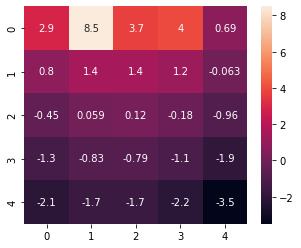

In [7]:
visuals(final_result, x=5, y=4)  # transition matrix visualization

Dynamic Programming

Monte Caro Methods

Timeporal-Difference Algorithms